# Prometheus Anomaly Detection
This notebook will give an introduction to how we can perform anomaly detection for Prometheus metrics using a machine learning time series forecasting model. Before we dive into the data science work, let's understand the problem.

## Understanding the Problem
Prometheus is the chosen application to do monitoring across multiple products and platforms. Prometheus metrics are time series data identified by metric name and key/value pairs. With the increased amount of metrics flowing in it is getting harder to see the signals within the noise. The current state of the art is to graph out metrics on dashboards and alert on thresholds. 

However, we can leverage machine learning algorithms to perform time series forecasting and predict an unusual behavior or pattern in the metrics. The predicted values from the model can be compared with the actual metric values and if they differ from the default threshold values, we can flag it as an **anomaly**. Before we start looking at any machine learning model, let's try to understand the data.

## Understanding the Data
As we saw in the previous Prometheus API client notebook, Prometheus metrics are time series data identified by:
* **metric name**
* **labels**

Open the Prometheus UI and see for yourself what the metrics look like!

Any given combination of labels for the same metric name identifies a particular dimensional instantiation of that metric. Each metric consists of a timestamp and its corresponding value at that timestamp. Prometheus comprises of four metric types:
* **Counter**
* **Gauge**
* **Histogram**
* **Summary**

You can find more details about these metrics here: https://prometheus.io/docs/concepts/metric_types/. 

In this notebook we will walk through some of the essential steps required for training a machine learning model to predict anomalies on a sample Prometheus time series metrics data set:

## Data Preparation & Data Exploration
Bad data or poor quality of data can alter the accuracy of insights or could lead to incorrect insights, which is why data preparation or data cleaning is of utmost importance even though it is one of the time consuming tasks of the data science process. Some of the tasks in our data pre-processing are:

* Load sample metric data set (Json)
* Convert the raw metric data into suitable pandas dataframe using the Prometheus API client
* Compress the timeseries into suitable (1h/ 0.5h/ 0.25/) frequency for training the model

## Model Data
This is when the real fun starts. Machine learning algorithms can help you go a step further into getting insights and predicting future trends. Once again, before reaching this stage, bear in mind that the scrubbing and exploring stage are equally crucial to building useful models. So take your time on those stages instead of jumping right to this process. During this stage we will:
* Train a ML model
* Forecast the predictions on a test data set
* Evaluate the predictions for detecting anomalies

To begin, let's install the required packages/modules

In [1]:
#We will be using the prometheus-api-client for data formatting
!pip3 install prometheus-api-client
!pip3 install pmdarima

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


These are all the required modules/packages needed for all the fancy data science work!

In [2]:
import os
import time
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import math

import json as JS
from json import load
from json import loads
from datetime import datetime

from pmdarima.arima import auto_arima
import statsmodels.api as sm
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
from prometheus_api_client.utils import parse_datetime, parse_timedelta

## Data Preparation

### Load and Explore Time Series Data

The dataset we will be using are Prometheus read/write metrics collected from a Dgraph application. Dgraph is an open-source, scalable, distributed, highly available and fast graph database, designed from the ground up to be run in production. The Dgraph instance provides metrics that follow Prometheus standards. One of the metrics are the disk metrics which track the disk activity of the Dgraph process. These metrics can be used for monitoring the read and write to persistent storage.

Here we are loading the dataset that contains the past 30 days of disk write metrics. 

In [3]:
raw_data = pd.read_json("metrics/prometheus-route-aiops-prod-prometheus-predict.cloud.paas.psi.redhat.com/badger_disk_writes:rate1m/1month of data (Aug 13-Sep 13)/201909131217.json")

In [4]:
#display the first few lines of the data
raw_data.head()

,metric,values
0,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1565799480.825, 0], [1565799540.825, 5.4], [..."
1,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1565799480.825, 0], [1565799540.825, 0], [15..."
2,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1565799480.825, 0], [1565799540.825, 5.4], [..."
3,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1565799480.825, 0], [1565799540.825, 5.4], [..."
4,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1565799480.825, 0], [1565799540.825, 19.95],..."


Let's understand the structure of the `raw_data`

In [5]:
print(type(raw_data))
print(len(raw_data))

<class 'pandas.core.frame.DataFrame'>
11


**Question 1**: Try loading and viewing any of the `disk_read` metrics data instead

### Data Pre-Processing

The raw data obtained from Prometheus is not very easy to understand nor is a suitable input for a machine learning model. To convert this raw data into an easier format we will make use of the Prometheus API Client.

As we saw in the previous notebook, the Prometheus API client has a `MetricsList` object that creates a list of `Metric` objects, where each object is unique for a specific time-series.

We will first convert the raw data into a `list` format as this is the input type required by the `MetricsList` function.

In [6]:
metric_data = raw_data.to_dict('records')

In [7]:
type(metric_data)

list

Now we can intitalize a `MetricsList` object.

In [8]:
metrics_object_list = MetricsList(metric_data)

In [9]:
print(len(metrics_object_list))
print(type(metrics_object_list))

11
<class 'prometheus_api_client.metrics_list.MetricsList'>


Let's look at one of the items in this `MetricsList` object created.

In [10]:
m = metrics_object_list[0]
print(m)

{
metric_name: 'badger_disk_writes:rate1m'
label_config: {'ae_source': 'http://prometheus-exporter-zero-0.thoth-dgraph-stage.svc:8080/debug/prometheus_metrics', 'instance': 'prometheus-aggregate-exporter-thoth-dgraph-stage.cloud.paas.psi.redhat.com:80', 'job': 'Thoth Dgraph aggregate-exporter (stage)', 'monitor': 'datahub'}
metric_values:                            ds       y
0     2019-08-14 16:18:00.825   0.000
1     2019-08-14 16:19:00.825   5.400
2     2019-08-14 16:20:00.825   0.000
3     2019-08-14 16:21:00.825   0.000
4     2019-08-14 16:22:00.825   0.000
5     2019-08-14 16:23:00.825   0.000
6     2019-08-14 16:24:00.825   0.000
7     2019-08-14 16:25:00.825   0.000
8     2019-08-14 16:26:00.825   0.000
9     2019-08-14 16:27:00.825   0.000
10    2019-08-14 16:28:00.825   0.000
11    2019-08-14 16:29:00.825   0.000
12    2019-08-14 16:30:00.825   0.000
13    2019-08-14 16:31:00.825   0.000
14    2019-08-14 16:32:00.825   0.000
15    2019-08-14 16:33:00.825   0.000
16    2019-08

However, we are only interested in the `metric_values` as this contains the timestamp and its corresponding metric value for which we want to train our machine learning model. So, lets extract only the metric values i.e the timestamp and its associated metric value.

In [11]:
m_values = m.metric_values
print(type(m_values))
print(m_values)

<class 'pandas.core.frame.DataFrame'>
                           ds       y
0     2019-08-14 16:18:00.825   0.000
1     2019-08-14 16:19:00.825   5.400
2     2019-08-14 16:20:00.825   0.000
3     2019-08-14 16:21:00.825   0.000
4     2019-08-14 16:22:00.825   0.000
5     2019-08-14 16:23:00.825   0.000
6     2019-08-14 16:24:00.825   0.000
7     2019-08-14 16:25:00.825   0.000
8     2019-08-14 16:26:00.825   0.000
9     2019-08-14 16:27:00.825   0.000
10    2019-08-14 16:28:00.825   0.000
11    2019-08-14 16:29:00.825   0.000
12    2019-08-14 16:30:00.825   0.000
13    2019-08-14 16:31:00.825   0.000
14    2019-08-14 16:32:00.825   0.000
15    2019-08-14 16:33:00.825   0.000
16    2019-08-14 16:34:00.825   0.000
17    2019-08-14 16:35:00.825   0.000
18    2019-08-14 16:36:00.825   0.000
19    2019-08-14 16:37:00.825   0.000
20    2019-08-14 16:38:00.825   0.000
21    2019-08-14 16:39:00.825   0.000
22    2019-08-14 16:40:00.825   0.000
23    2019-08-14 16:41:00.825   0.000
24    2019-0

### Data Sampling
As you can see, this data consists of metric values that are generated per **minute**, resulting in a large number of data points which may take a considerate amount of time when training the model. Hence, we will compress this data to a **hourly** frequency for the purpose of this workshop.

In [12]:
freq = '1h' # Here we are setting the frequency to hourly, but we can also set this to be half-hourly or daily etc

#Converting the dataframe to a single column with the timestamp column set as index
m_values = m_values.set_index('ds')

m_values = m_values.resample(freq).mean()
m_values = m_values.dropna()

Let's now look at the compressed data.

In [13]:
print(len(m_values))
print(m_values)

721
                             y
ds                            
2019-08-14 16:00:00   4.660627
2019-08-14 17:00:00  16.956046
2019-08-14 18:00:00  10.935411
2019-08-14 19:00:00  10.280431
2019-08-14 20:00:00   1.451667
2019-08-14 21:00:00   0.684167
2019-08-14 22:00:00   0.000000
2019-08-14 23:00:00   1.218333
2019-08-15 00:00:00  17.303737
2019-08-15 01:00:00  18.721215
2019-08-15 02:00:00  27.212932
2019-08-15 03:00:00  21.176692
2019-08-15 04:00:00  18.977896
2019-08-15 05:00:00  16.302868
2019-08-15 06:00:00  16.445853
2019-08-15 07:00:00  25.498633
2019-08-15 08:00:00  17.704142
2019-08-15 09:00:00  19.119175
2019-08-15 10:00:00  35.384672
2019-08-15 11:00:00  27.904741
2019-08-15 12:00:00   3.198761
2019-08-15 13:00:00   3.035821
2019-08-15 14:00:00   0.008333
2019-08-15 15:00:00   8.582893
2019-08-15 16:00:00   0.008333
2019-08-15 17:00:00   0.712082
2019-08-15 18:00:00   2.828306
2019-08-15 19:00:00   0.135000
2019-08-15 20:00:00   0.000000
2019-08-15 21:00:00   0.000000
... 

Let's reduce the size of the data to say about 100 data points. This is just for the sake of the workshop and to save us some time during model training.

In [14]:
m_values = m_values[:100]
print(m_values)
len(m_values)

                             y
ds                            
2019-08-14 16:00:00   4.660627
2019-08-14 17:00:00  16.956046
2019-08-14 18:00:00  10.935411
2019-08-14 19:00:00  10.280431
2019-08-14 20:00:00   1.451667
2019-08-14 21:00:00   0.684167
2019-08-14 22:00:00   0.000000
2019-08-14 23:00:00   1.218333
2019-08-15 00:00:00  17.303737
2019-08-15 01:00:00  18.721215
2019-08-15 02:00:00  27.212932
2019-08-15 03:00:00  21.176692
2019-08-15 04:00:00  18.977896
2019-08-15 05:00:00  16.302868
2019-08-15 06:00:00  16.445853
2019-08-15 07:00:00  25.498633
2019-08-15 08:00:00  17.704142
2019-08-15 09:00:00  19.119175
2019-08-15 10:00:00  35.384672
2019-08-15 11:00:00  27.904741
2019-08-15 12:00:00   3.198761
2019-08-15 13:00:00   3.035821
2019-08-15 14:00:00   0.008333
2019-08-15 15:00:00   8.582893
2019-08-15 16:00:00   0.008333
2019-08-15 17:00:00   0.712082
2019-08-15 18:00:00   2.828306
2019-08-15 19:00:00   0.135000
2019-08-15 20:00:00   0.000000
2019-08-15 21:00:00   0.000000
...     

100

**Question 2**: How does the data look when we sample it differently? For example, instead of `hourly` try resampling the raw data to generate data of `daily` frequency.

We now have a much smaller dataset that we can look at. For training any machine learning model, we need to first split the data into `training` and `testing` datasets. 

* **Training** - The actual dataset that we use to train the model. The model sees and learns from this data
* **Testing** - The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset

Now that you know what these datasets do, we will split the dataset into Train and Test sets.

[*As a rule of thumb, 80/20 is a good ratio to start with for splitting up the data into training and testing sets.]

In [15]:
def split_data(dataframe):
    #Dividing the data set into (80%)training and (20%)testing samples
    dataframe = dataframe.sort_values(by = 'ds')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    return train, test

In [16]:
train, test = split_data(m_values)

In [17]:
print(len(train))
print(len(test))

80
20


## Model Data
We are now ready to train a time seriers forecasting model. Here, we will train the SARIMA model i.e. Seasonal Auto-Regressive Moving Average model.

### What is SARIMA?
Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting. Although this method can handle data with a trend, it does not support time series with a seasonal component i.e. time series with a repeating cycle. An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

SARIMA adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

### What are hyperparameters?
They are simply the very "knobs" one "turns" when building/tuning a statistical learning model. A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data. These hyperparametrs effect the speed and quality of the model training process. Different model training algorithms require different hyperparameters, some simple algorithms (such as ordinary least squares regression) require none. Given these hyperparameters, the training algorithm learns the parameters from the data. 

We cannot know the best value for a model hyperparameter on a given problem. We may use rules of thumb, copy values used on other problems, or search for the best value by trial and error.

When a machine learning algorithm is tuned for a specific problem, then you are tuning the hyperparameters of the model or order to discover the parameters of the model that result in the most skillful predictions.

### How to configure SARIMA?
Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. There are three **trend** elements that require configuration. These are the ones that are configured in the standard ARIMA model.

* **p** - Trend autoregression order (AR part)

 - *It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.*

* **d** - Trend difference order (I part)

 - *It is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.*

* **q** - Trend moving average order (MA part)

 - *It is the number of lagged forecast errors in the prediction equation. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.*

There are four **seasonal** elements that are not part of ARIMA that must be configured; they are:

* **P**: Seasonal autoregressive order.
* **D**: Seasonal difference order.
* **Q**: Seasonal moving average order.
* **m**: The number of time steps for a single seasonal period.

The Seasonal portion `(P, D, Q)m` has the same structure as the non-seasonal parts. It may — but does not have to include — an AR factor, an MA factor, and/or an I factor. In this part of the model, all of these factors operate across the number of period `(m)` in your season. This seasonality is a regular pattern of changes that repeats over `m` time periods. E.g. If there is a seasonal factor of 3 over a time series of monthly data, the pattern repeats every quarter.

Put these all together and you get a `SARIMA (p, d, q) x (P, D, Q)m` which is what we’re looking to build.

The exact model we’ll be using from the python package `statsmodels` is the `SARIMAX`, where `X` is the use of an exogenous explanatory variable (the X part of SARIMAX). We’re not going to get into adding exogenous variables to our model, so you can ignore this for now. The default will be `none` when we run the model as we don't have any extra variable to include at the moment.

Together, the notation for a SARIMA model is specified as:

```
SARIMAX(order=(p,d,q), seasonal_order=(P,D,Q,m))
```
Source: http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html


### Finding the hyperparameters
In order to find the most optimized hyperparameters for the model and the given dataset, we carried out a Grid search method. Grid-searching is the process of scanning the data to configure optimal parameters for a given model. It is important to note that Grid-searching can be extremely computationally expensive and may take your machine quite a long time to run. Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. We then choose the model/hyperparameters which resulted in the best accuracy or low error rates. 

A good explanation of how this is done can be found here: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

Hence to save time and make things easier for you, we have already identified the optimized parameter values required to train the SARIMA model for this particular dataset. The values were found to be:
* **p** = 1
* **d** = 2
* **q** = 2
* **P** = 2
* **D** = 2
* **Q** = 2

Now, we need to identify the relvant value for `m` which indicates the seasonality order for our data. Seasonality is the presence of any predictable fluctuation or pattern that recurs/repeats over regular intervals. For example, data with daily observations might have a weekly seasonality (frequency=7) or an annual seasonality (frequency=365.25). Similarly, data that are observed every minute might have an hourly seasonality (frequency=60), a daily seasonality (frequency=24x60=1440), a weekly seasonality (frequency=24x60x7=10080) and an annual seasonality (frequency=24x60x365.25=525960).

The raw data obtained from Prometheus for the disk write metric was observed every minute and had a **daily** seasonality. So, depending on how you resample your data i.e. whether it is hourly,minutely,daily etc we can determine the corresponding daily seasonality order. For example, if the data is sampled to be `hourly` then `m = 24 (i.e. 1 day = 24 hours)`. 

You can read more about finding the seasonal periods here: https://robjhyndman.com/hyndsight/seasonal-periods/

We now define the `_sarima()` function which performs the following tasks:
    * Training the model
    * Fitting the model
    * Interpretting the model forecast
    * Plotting the forecasted values
    * Plotting the forecasted vs actual/test data values

In [18]:
def _sarima(train, test, freq):
    #Determining the seasonal order for the corresponding frequency of data
    sfrequency = 0
    if freq == '1h':
        sfrequency = 24
    elif freq == '30Min':
        sfrequency = 48
    elif freq == '15Min':
        sfrequency = 96
    elif freq == '1d':
        sfrequency = 24
        
    model = SARIMAX(train, order=(1, 2, 2), seasonal_order=(2,2,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    model_fit = model.fit(dsip=-1)
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    print("Now plotting the residual errors for the SARIMA model")
    plt.show()
    residuals.plot(kind='kde')
    print("Now plotting the desity of the residual error values.")
    plt.show()
    print(residuals.describe())
    K = len(test)

    forecast = model_fit.forecast(K)
    forecast = pd.DataFrame(forecast.values, columns = ['predict'], index = test.index)

    plt.plot(forecast, label='forecast')
    print("Now plotting the forecasted values.")
    plt.show()
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    plt.legend(loc='upper left', fontsize=8)
    print("Now plotting the forecasted vs the test data.")
    plt.show()
    return model, model_fit, forecast

Now that our SARIMA model function is defined, we can train the model with our dataset by specifying the frequency of the resampled dataset.

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Now plotting the residual errors for the SARIMA model


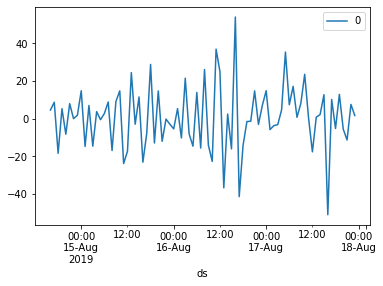

Now plotting the desity of the residual error values.


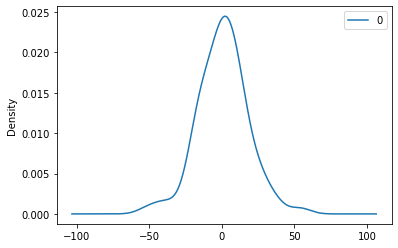

               0
count  80.000000
mean    0.716187
std    17.093191
min   -50.923560
25%   -10.437712
50%     0.813088
75%     9.476649
max    54.037755
Now plotting the forecasted values.


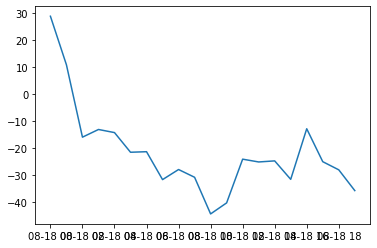

Now plotting the forecasted vs the test data.


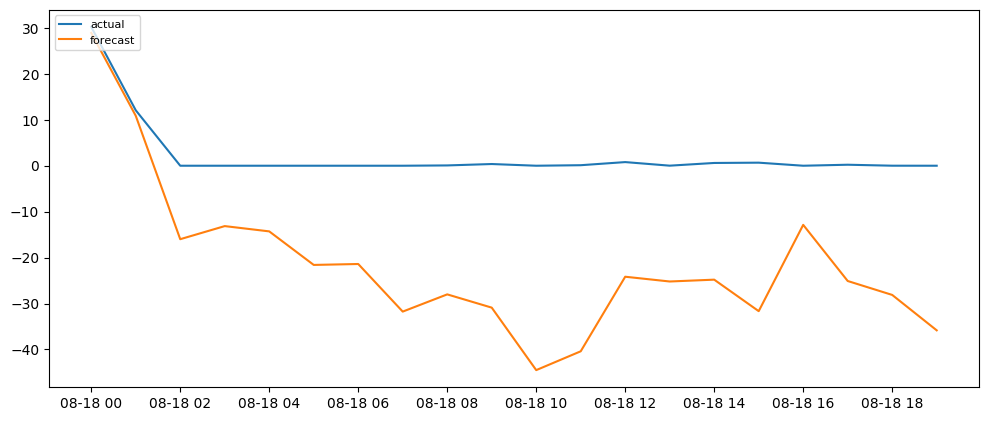

In [19]:
#Here we specify the frequency of our data i.e. whether it is minutely/hourly/daily etc data. If you resampled your data differently, remember to indicate this change here as well
freq='1h'
model, model_fit, forecast = _sarima(train, test, freq)

### Interpretting the Model Forecast
#### Residuals
The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values. Residuals are useful in checking whether a model has adequately captured the information in the data. 

Generally, when exploring residual errors we are looking for patterns or structure. A sign of a pattern suggests that the errors are not random.

We expect the residual errors to be random, because it means that the model has captured all of the structure and the only error left is the random fluctuations in the time series that cannot be modeled.

A sign of a pattern or structure suggests that there is more information that a model could capture and use to make better predictions.

#### Residual Summary Statistics
We can also calculate summary statistics on the residual errors to understand their distribution. This includes the mean and standard deviation of the distribution, as well as percentiles and the minimum and maximum errors observed.

Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation. Plots can be used to better understand the distribution of errors beyond summary statistics. We can use either histograms or density plots to better understand the distribution of residual errors.

**Question 3** - Try changing the hyperparameter values (p,d,q,P,D,Q,m) and see how this affects the model's performance in detecting anomalies.

**Question 4** - Try to interpret the residual summary statistics obtained. Do these results suggest that the model can be further improved? 

[Hint: Observe whether the mean value is 0, positive or negative]

## Model Evaluation
Now that the model has successfully completed training, let's identify anomalies by comparing the `predicted` values with the `actual` values (test dataset). To do so, we will define `upper` and `lower` bounds based on the range of predictions made by the model. If the actual metric value does not lie within these defined bounds, we will flag that as an anomaly.

* **Upper bound** - Calculated as the **sum** of the predicted value and (2x its standard deviation)
* **Lower bound** - Calculated as the **difference** between the predicted value and (2x its standard deviation)
* **Anomaly** - Boolean value where 1 is an anomaly and 0 is not an anomaly
    - If, (actual value < lower bound) **or** (actual value > upper bound) then anomaly = 1
    - Else, anomaly = 0
    
We can plot a graph of the **forecasted values, actual values, upper bound, lower bound and the anomaly detected** to understand how the machine learning model performed.

In [20]:
def evaluation(forecast, test):
    #Calculating the upper and lower bounds
    upper_bound = np.array(
      [
        (
         forecast['predict'][i]
          + (np.std(forecast[:i])*2)
        )
        for i in range(len(forecast))
        ]
    )

    lower_bound = np.array(
      [
        (
          forecast['predict'][i]
          - (np.std(forecast[:i])*2)
        )
        for i in range(len(forecast))
        ]
    )

    compare = test.join(forecast, how = 'outer')
    compare = compare.dropna()
    lower = pd.DataFrame(lower_bound, columns = [0], index = test.index)
    upper = pd.DataFrame(upper_bound, columns = [0], index = test.index)

    compare.insert(2, "LowerBound", lower, True)
    compare.insert(3, "UpperBound", upper, True)
    compare['WithinUpperBounds'] = compare['predict'] < compare['UpperBound']
    compare['WithinLowerBounds'] = compare['predict'] > compare['LowerBound']
    
    #Detecting anomalies
    anomaly = []
    for i in range(len(compare)):
        if((compare['y'][i] < compare['UpperBound'][i]) and (compare['y'][i] > compare['LowerBound'][i])):
            anomaly.append(0)
        else:
            anomaly.append(1)
    
    compare.insert(6, "Anomaly", anomaly, True)
    print("The final dataframe with lowerbound, upperbound and prediction value:\n")
    print(compare)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(compare['predict'], label='Predicted')
    plt.plot(compare['LowerBound'], label='LowerBound')
    plt.plot(compare['UpperBound'], label='UpperBound')
    plt.plot(compare['y'], label='Actual')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

Now, lets evaluate the forecasted values with the `test` data set to identify anomalies.

The final dataframe with lowerbound, upperbound and prediction value:

                             y    predict  LowerBound  UpperBound  \
ds                                                                  
2019-08-18 00:00:00  30.210392  28.906067         NaN         NaN   
2019-08-18 01:00:00  12.070554  10.870859   10.870859   10.870859   
2019-08-18 02:00:00   0.000000 -15.990590  -34.025799    2.044618   
2019-08-18 03:00:00   0.000000 -13.140990  -50.034326   23.752347   
2019-08-18 04:00:00   0.000000 -14.291799  -51.085685   22.502087   
2019-08-18 05:00:00   0.000000 -21.592454  -57.187028   14.002120   
2019-08-18 06:00:00   0.000000 -21.390207  -57.412824   14.632410   
2019-08-18 07:00:00   0.000000 -31.751255  -67.203765    3.701255   
2019-08-18 08:00:00   0.065833 -28.002895  -65.086304    9.080513   
2019-08-18 09:00:00   0.370000 -30.888073  -67.675552    5.899407   
2019-08-18 10:00:00   0.000000 -44.489175  -81.216205   -7.762145   
2019-08-18 11:00:00   0.112917 -

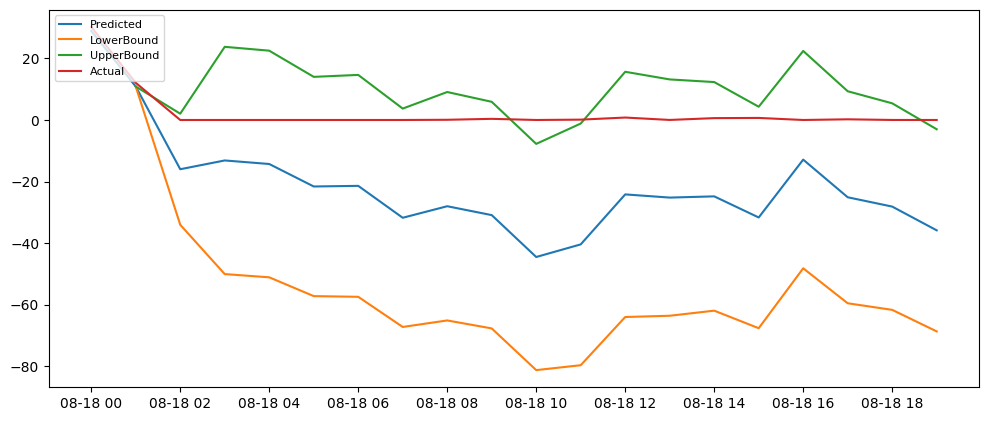

In [21]:
evaluation(forecast, test)

**Question 5** - Now, train the model with `disk_reads` metrics. Try looking at different datasets (30 days vs 90 days) and see how the model performs!

# END

We hope you enjoyed this workshop and learnt some fun stuff on leveraging AI/ML for detecting anomalies using Prometheus. Know any other interesting model that can perform time series forecasting? We would be more than happy to have your contributions towards improving this project! 